### Introduction to TensorFlow
    Welcome to this week's programming assignment! Up until now, you've always used Numpy to build neural networks, but this week you'll explore a deep learning framework that allows you to build neural networks more easily. Machine learning frameworks like TensorFlow, PaddlePaddle, Torch, Caffe, Keras, and many others can speed up your machine learning development significantly. TensorFlow 2.3 has made significant improvements over its predecessor, some of which you'll encounter and implement here!

By the end of this assignment, you'll be able to do the following in TensorFlow 2.3:

- Use tf.Variable to modify the state of a variable
- Explain the difference between a variable and a constant
- Train a Neural Network on a TensorFlow dataset
- Programming frameworks like TensorFlow not only cut down on time spent coding, but can also perform optimizations that speed up the code itself.

**Table of Contents**

- 1- Packages
    - 1.1 - Checking TensorFlow Version
- 2 - Basic Optimization with GradientTape
    - 2.1 - Linear Function
        - Exercise 1 - linear_function
    - 2.2 - Computing the Sigmoid
        - Exercise 2 - sigmoid
    - 2.3 - Using One Hot Encodings
        - Exercise 3 - one_hot_matrix
    - 2.4 - Initialize the Parameters
        - Exercise 4 - initialize_parameters
- 3 - Building Your First Neural Network in TensorFlow
    - 3.1 - Implement Forward Propagation
        - Exercise 5 - forward_propagation
    - 3.2 Compute the Total Loss
        - Exercise 6 - compute_total_loss
    - 3.3 - Train the Model
- 4 - Bibliography

### 1 - Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import h5py
from tensorflow.keras.optimizers import Adam
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
from tensorflow.python.framework.ops import EagerTensor
import time

#### 1.1 - Checking TensorFlow Version

In [2]:
tf.__version__

'2.13.0'

### 2 - Basic Optimization with GradientTape

    The beauty of TensorFlow 2 is in its simplicity. Basically, all you need to do is implement forward propagation through a computational graph. TensorFlow will compute the derivatives for you, by moving backwards through the graph recorded with GradientTape. All that's left for you to do then is, specify the cost function and optimizer you want to use!

    When writing a TensorFlow program, the main object to get used and transformed is the tf.Tensor. These tensors are the TensorFlow equivalent of Numpy arrays, i.e. multidimensional arrays of a given data type that also contain information about the computational graph.

    Below, you'll use tf.Variable to store the state of your variables. Variables can only be created once as its initial value defines the variable shape and type. Additionally, the dtype arg in tf.Variable can be set to allow data to be converted to that type. But if none is specified, either the datatype will be kept if the initial value is a Tensor, or convert_to_tensor will decide. It's generally best for you to specify directly, so nothing breaks!

    Here you'll call the TensorFlow dataset created on a HDF5 file, which you can use in place of a Numpy array to store your datasets. You can think of this as a TensorFlow data generator!

    You will use the Hand sign data set, that is composed of images with shape 64x64x3.

In [5]:
train_data = h5py.File("./data/train_signs.h5", "r")
test_data = h5py.File("./data/test_signs.h5", "r")

In [20]:
print("Train Data:")
print(train_data.keys())
print(train_data["train_set_x"].shape)
print(train_data["train_set_y"].shape)
print(np.unique(train_data["train_set_y"]))
print("Test Data")
print(test_data.keys())
print(test_data["test_set_x"].shape)
print(test_data["test_set_y"].shape)
print(np.unique(test_data["test_set_y"]))

Train Data:
<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
(1080, 64, 64, 3)
(1080,)
[0 1 2 3 4 5]
Test Data
<KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>
(120, 64, 64, 3)
(120,)
[0 1 2 3 4 5]


In [6]:
#Load the data
train_x = tf.data.Dataset.from_tensor_slices(train_data["train_set_x"])
train_y = tf.data.Dataset.from_tensor_slices(train_data["train_set_y"])

test_x = tf.data.Dataset.from_tensor_slices(test_data["test_set_x"])
test_y = tf.data.Dataset.from_tensor_slices(test_data["test_set_y"])

In [28]:
type(train_x)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

    Since TensorFlow Datasets are generators, you can't access directly the contents unless you iterate over them in a "for loop", or by explicitly creating a Python iterator "using iter and consuming its elements using next". Or you can even use "list(dataset.as_numpy_iterator())" to access the elements after slicing
    
    Also, you can inspect the shape and dtype of each element using the "element_spec attribute".

In [29]:
print(train_x.element_spec)

TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)


In [27]:
#To get the whole dataset and its shape
# print(train_x._tensors)
print(train_x._tensors[0].shape)
print(test_x._tensors[0].shape)

(1080, 64, 64, 3)
(120, 64, 64, 3)


 Accessing the elements using python iter and next

In [30]:
print(next(iter(train_x)))

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


    The dataset that you'll be using during this assignment is a subset of the sign language digits. It contains six different classes representing the digits from 0 to 5.

In [31]:
unique_labels = set()
for element in train_y:
    unique_labels.add(element.numpy())
    
print(unique_labels)

{0, 1, 2, 3, 4, 5}


    You can see some of the images in the dataset by running the following cell.

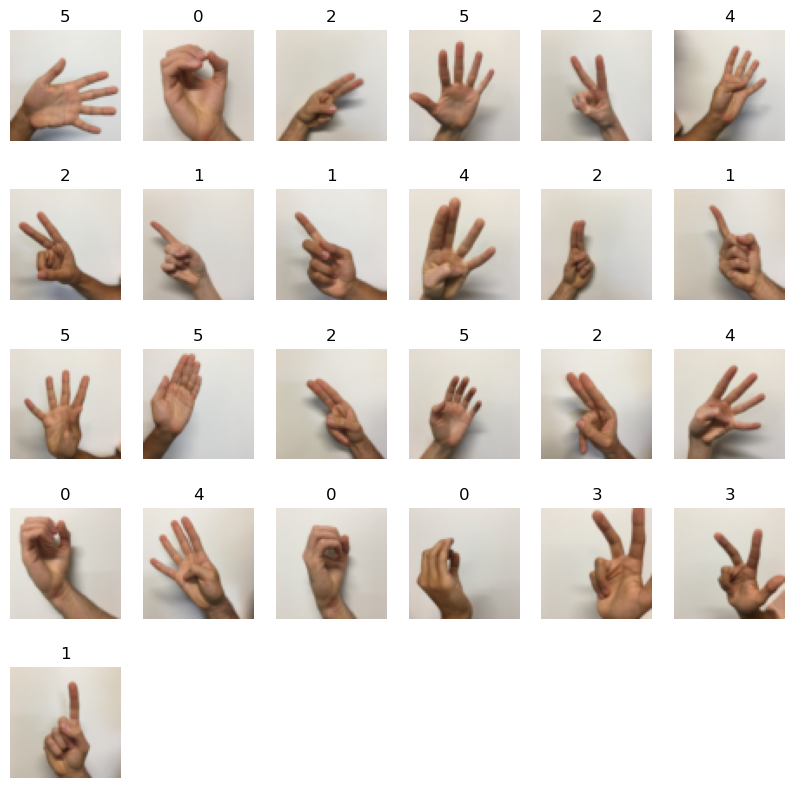

In [35]:
images_iter = iter(train_x)
labels_iter = iter(train_y)
figure = plt.figure(figsize=(10, 10))
for i in range(25):
    ax = plt.subplot(5, 6, i+1)
    plt.imshow(next(images_iter).numpy().astype("uint8"))
    plt.title(next(labels_iter).numpy().astype("uint8"))
    plt.axis("off")
plt.show()

    There's one more additional difference between TensorFlow datasets and Numpy arrays: If you need to transform one, you would invoke the map method to apply the function passed as an argument to each of the elements.

In [34]:
def normalize(image):
    """
    Transform an image into a tensor of shape (64 * 64 * 3, )
    and normalize its components.
    
    Arguments
    image - Tensor.
    
    Returns: 
    result -- Transformed tensor 
    """
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [-1,])
#     print(image.shape) #(12288,)
    return image

In [35]:
#transformations of using map
train_x_scaled = train_x.map(normalize) #usual shape of one element (1, 12288)
test_x_scaled = test_x.map(normalize)

**map() and apply()**

    The difference is that map will execute one function on every element of the Dataset separately, whereas apply will execute one function on the whole Dataset at once (such as group_by_window given as example in the documentation).

    The argument of apply is a function that takes a Dataset and returns a Dataset when the argument of map is a function that takes one element and returns one transformed element.

In [36]:
print(type(train_x_scaled)) #note earlier it was tensorslicedataset

<class 'tensorflow.python.data.ops.map_op._MapDataset'>


In [37]:
train_x_scaled

<_MapDataset element_spec=TensorSpec(shape=(12288,), dtype=tf.float32, name=None)>

In [38]:
train_x_scaled.element_spec #each element has shape 12288

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [39]:
test_x_scaled.element_spec

TensorSpec(shape=(12288,), dtype=tf.float32, name=None)

In [40]:
print(next(iter(train_x_scaled)))

tf.Tensor([0.8901961  0.8627451  0.8392157  ... 0.8156863  0.81960785 0.81960785], shape=(12288,), dtype=float32)


### 2.1 - Linear Function
    Let's begin this programming exercise by computing the following equation: Y = W. X + b, where W and X are random matrices and b is a random vector.

#### Exercise 1 - linear_function
    Compute W X + b where W, X and b are drawn from a random normal distribution. 
 
    W is of shape (4, 3), X is (3, 1) and b is (4, 1). As an example, this is how to define a constant X with the shape (3, 1):

**X = tf.constant(np.random.randn(3, 1), name = "X")**
                
    Note that the difference between tf.constant and tf.Variable is that you can modify the state of a tf.Variable but cannot change the state of a tf.constant.

    You might find the following functions helpful:

**tf.matmul(..., ...) to do a matrix multiplication**

**tf.add(..., ...) to do an addition**

**np.random.randn(...) to initialize randomly**

In [41]:
def linear_function():
    """
    Implements a linear function: 
            Initializes X to be a random tensor of shape (3,1)
            Initializes W to be a random tensor of shape (4,3)
            Initializes b to be a random tensor of shape (4,1)
    Returns: 
    result -- Y = WX + b 
    """
    np.random.seed(1)
    X = tf.constant(np.random.randn(3, 1), name="X")
    W = tf.constant(np.random.randn(4, 3), name="W")
    b = tf.constant(np.random.randn(4, 1), name="b")
    
    Y = tf.add(tf.matmul(W, X), b)
    
    return Y

In [53]:
#test the function
result = linear_function()
print(type(result))
print(result)

assert type(result) == EagerTensor, "Use the Tensorflow Api"
assert np.allclose(result, [[-2.15657382], [ 2.95891446], [-1.08926781], [-0.84538042]]), "Error"
print("\033[92m All tests are passed")

<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]], shape=(4, 1), dtype=float64)
 All tests are passed


https://community.deeplearning.ai/t/what-is-eager-tensor-eager-execution/341637

### 2.2 - Computing the Sigmoid
    Amazing! You just implemented a linear function. TensorFlow offers a variety of commonly used neural network functions like tf.sigmoid, tf.softmax, tf.nn.sigmoid, tf.nn.sigmoid_cross_entropy_with_logits, tf.nn.softmax, tf.keras.activation.relu

    For this exercise, compute the sigmoid of z.

    In this exercise, you will: Cast your tensor to type float32 using tf.cast, then compute the sigmoid using tf.keras.activations.sigmoid.


#### Exercise 2 - sigmoid
    Implement the sigmoid function below. You should use the following:

**tf.cast("...", tf.float32)**

**tf.keras.activations.sigmoid("...")**

In [54]:
def sigmoid(z):
    
    """
    Computes the sigmoid of z
    
    Arguments:
    z -- input value, scalar or vector
    
    Returns: 
    a -- (tf.float32) the sigmoid of z
    """
    z = tf.cast(z, tf.float32)
    a = tf.keras.activations.sigmoid(z)
    return a

In [62]:
result = sigmoid(-1)
print(result)
print ("type: " + str(type(result))) # Note this is tensor
print ("dtype: " + str(result.dtype)) #Note this is type of data inside the tensor i.e float32
print ("sigmoid(-1) = " + str(result))
print ("sigmoid(0) = " + str(sigmoid(0.0)))
print ("sigmoid(12) = " + str(sigmoid(12)))

#test the function
def sigmoid_test(target):
    a = target(0)
    
    assert(type(a) == EagerTensor), "Use Tensorflow"
    assert(a.dtype == tf.float32)
    assert target(0) == 0.5, "Error"
    assert target(-1) == 0.26894143 , "Error"
    assert target(12) == 0.99999386, "Error"
    
    print("\033[92m All tests passed")
    
sigmoid_test(sigmoid)

tf.Tensor(0.26894143, shape=(), dtype=float32)
type: <class 'tensorflow.python.framework.ops.EagerTensor'>
dtype: <dtype: 'float32'>
sigmoid(-1) = tf.Tensor(0.26894143, shape=(), dtype=float32)
sigmoid(0) = tf.Tensor(0.5, shape=(), dtype=float32)
sigmoid(12) = tf.Tensor(0.99999386, shape=(), dtype=float32)
 All tests passed


### 2.3 - Using One Hot Encodings
    Many times in deep learning you will have a Y vector with numbers ranging from 0 to C-1 , where C is the number of classes. If C is for example 4, then you might have the following y vector which you will need to convert like this:
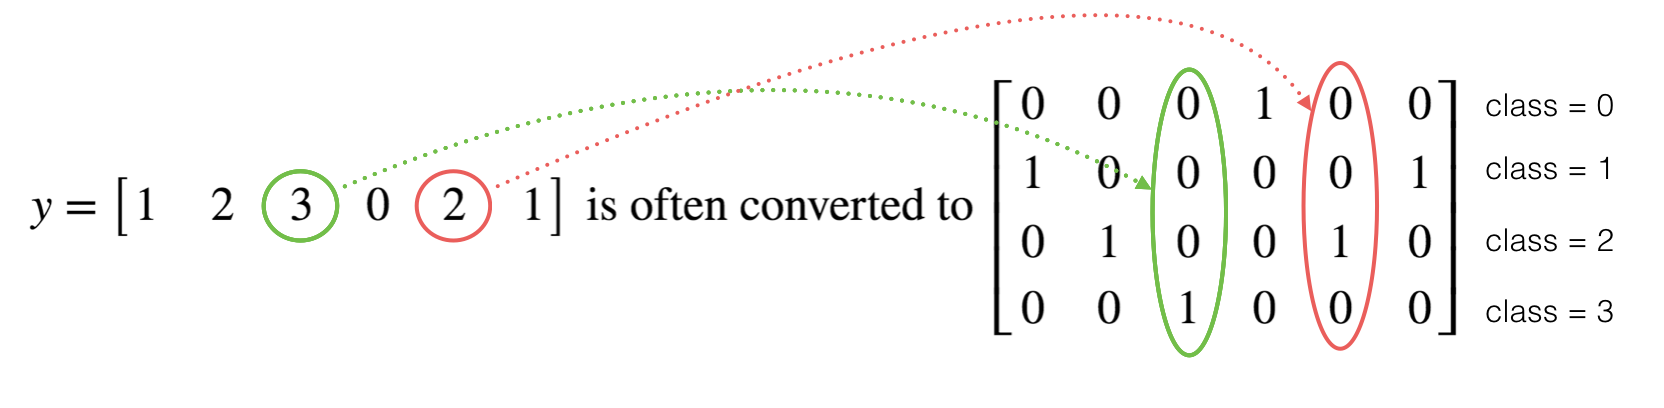

    This is called "one hot" encoding, because in the converted representation, exactly one element of each column is "hot" (meaning set to 1). To do this conversion in numpy, you might have to write a few lines of code. In TensorFlow, you can use one line of code:

**tf.one_hot(labels, depth, axis=0)**
    
    axis=0 indicates the new axis is created at dimension 0


#### Exercise 3 - one_hot_matrix
    Implement the function below to take one label and the total number of classes C, and return the one hot encoding in a column wise matrix. Use tf.one_hot() to do this, and tf.reshape() to reshape your one hot tensor!

**tf.reshape(tensor, shape)**

In [73]:
def one_hot_matrix(label, depth=6):
    """
    Computes the one hot encoding for a single label
    
    Arguments:
        label --  (int) Categorical labels
        depth --  (int) Number of different classes that label can take
    
    Returns:
         Y_one_hot_reshaped -- tf.Tensor A single-column matrix with the one hot encoding.
    """
    Y_one_hot = tf.one_hot(indices=label, depth=depth, axis=0)
    Y_one_hot_reshaped = tf.reshape(Y_one_hot, (depth,))
    
    return Y_one_hot_reshaped 

In [75]:
#test the function
def one_hot_matrix_test(target):
    label = tf.constant(1)
    depth = 4
    result = target(label, depth)
    
    print("Test 1:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 1. ,0., 0.] ), "Wrong output. Use tf.one_hot"
    
    label_2 = [2]
    result = target(label_2, depth)
    
    print("Test 2:", result)
    assert result.shape[0] == depth, "Use the parameter depth"
    assert np.allclose(result, [0., 0. ,1., 0.] ), "Wrong output. Use tf.reshape as instructed"
    
    print("\033[92mAll test passed")

one_hot_matrix_test(one_hot_matrix)

Test 1: tf.Tensor([0. 1. 0. 0.], shape=(4,), dtype=float32)
Test 2: tf.Tensor([0. 0. 1. 0.], shape=(4,), dtype=float32)
All test passed


In [76]:
#lets one hot encode the train_y and test_y using map(so one element at a time is one hot encoded, not all m elements)
new_train_y = train_y.map(one_hot_matrix)
new_test_y = test_y.map(one_hot_matrix) #usual shape of one element (1, 6)

In [78]:
print(next(iter(new_test_y)))

tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)


### 2.4 - Initialize the Parameters
    Now you'll initialize a vector of numbers with the Glorot initializer(the one proposed LeCunn) sqrt(2 / n_in + n_out). The function you'll be calling is tf.keras.initializers.GlorotNormal, which draws samples from a truncated normal distribution centered on 0, with stddev = sqrt(2 / (fan_in + fan_out)), where fan_in is the number of input units and fan_out is the number of output units, both in the weight tensor.

    To initialize with zeros or ones you could use tf.zeros() or tf.ones() instead.


#### Exercise 4 - initialize_parameters
    Implement the function below to take in a shape and to return an array of numbers using the GlorotNormal initializer.

**tf.keras.initializers.GlorotNormal(seed=1)**

**tf.Variable(initializer(shape=())**

In [47]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with TensorFlow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    params -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    W1 = tf.Variable(initializer(shape=(25, 12288)))
    b1 = tf.Variable(initializer(shape=(25, 1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6, 12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))
    
    params = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    return params

In [81]:
#test the function
def initialize_parameters_test(target):
    parameters = target()

    values = {"W1": (25, 12288),
              "b1": (25, 1),
              "W2": (12, 25),
              "b2": (12, 1),
              "W3": (6, 12),
              "b3": (6, 1)}

    for key in parameters:
        print(f"{key} shape: {tuple(parameters[key].shape)}")
        assert type(parameters[key]) == ResourceVariable, "All parameter must be created using tf.Variable"
        assert tuple(parameters[key].shape) == values[key], f"{key}: wrong shape"
        assert np.abs(np.mean(parameters[key].numpy())) < 0.5,  f"{key}: Use the GlorotNormal initializer"
        assert np.std(parameters[key].numpy()) > 0 and np.std(parameters[key].numpy()) < 1, f"{key}: Use the GlorotNormal initializer"

    print("\033[92mAll test passed")
    
initialize_parameters_test(initialize_parameters)

W1 shape: (25, 12288)
b1 shape: (25, 1)
W2 shape: (12, 25)
b2 shape: (12, 1)
W3 shape: (6, 12)
b3 shape: (6, 1)
All test passed


In [82]:
parameters = initialize_parameters()

### 3 - Building Your First Neural Network in TensorFlow
    In this part of the assignment you will build a neural network using TensorFlow. Remember that there are two parts to implementing a TensorFlow model:

- Implement forward propagation
- Retrieve the gradients and train the model

Let's get into it!

### 3.1 - Implement Forward Propagation
    One of TensorFlow's great strengths lies in the fact that you only need to implement the forward propagation function and it will keep track of the operations you did to calculate the back propagation automatically.

#### Exercise 5 - forward_propagation
    Implement the forward_propagation function.

    Note Use only the TF API.

**tf.math.add**

**tf.linalg.matmul**

**tf.keras.activations.relu**

In [44]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = tf.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.math.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.matmul(W3, A2) + b3
    
    return Z3

In [49]:
#test the function
def forward_propagation_test(target, examples):
    minibatches = examples.batch(2)
    print(minibatches)
    print(len(list(minibatches))) #2 examples in each batch, so total 1080 / 2 = 540 batches and each batch is of 2 examples 
    
    parametersk = initialize_parameters()
    
    W1 = parametersk['W1']
    b1 = parametersk['b1']
    W2 = parametersk['W2']
    b2 = parametersk['b2']
    W3 = parametersk['W3']
    b3 = parametersk['b3']
    
    index = 0
    minibatch = list(minibatches)[0] #first minibatch of 2 examples
    print(minibatch.shape) #usual shape (m, n) #(2, 12288)
    with tf.GradientTape() as tape:
        forward_pass = target(tf.transpose(minibatch), parametersk) #transposing to (n, m) for forwardprop
        print(forward_pass)
        fake_cost = tf.reduce_mean(forward_pass - np.ones((6, 2))) #(C, m), (C, m)

        assert type(forward_pass) == EagerTensor, "Your output is not a tensor"
        assert forward_pass.shape == (6, 2), "Last layer must use W3 and b3"
        assert np.allclose(forward_pass, 
                           [[-0.13430887,  0.14086473],
                            [ 0.21588647, -0.02582335],
                            [ 0.7059658,   0.6484556 ],
                            [-1.1260961,  -0.9329492 ],
                            [-0.20181894, -0.3382722 ],
                            [ 0.9558965,   0.94167566]]), "Output does not match"
    index = index + 1
    trainable_variables = [W1, b1, W2, b2, W3, b3]
    grads = tape.gradient(fake_cost, trainable_variables)
    assert not(None in grads), "Wrong gradients. It could be due to the use of tf.Variable whithin forward_propagation"
    print("\033[92mAll test passed")

forward_propagation_test(forward_propagation, train_x_scaled)

<_BatchDataset element_spec=TensorSpec(shape=(None, 12288), dtype=tf.float32, name=None)>
540
(2, 12288)
tf.Tensor(
[[-0.13430876  0.14086482]
 [ 0.21588624 -0.02582356]
 [ 0.7059656   0.6484557 ]
 [-1.126096   -0.9329494 ]
 [-0.20181876 -0.3382723 ]
 [ 0.95589626  0.9416754 ]], shape=(6, 2), dtype=float32)
All test passed


### 3.2 Compute the Total Loss
    All you have to do now is define the loss function that you're going to use. For this case, since we have a classification problem with 6 labels, a categorical cross entropy will work!

#### Exercise 6 - compute_total_loss
    Implement the total loss function below. You will use it to compute the total loss of a batch of samples. With this convenient function, you can sum the losses across many batches, and divide the sum by the total number of samples to get the cost value.

    It's important to note that the "y_pred" and "y_true" inputs of tf.keras.losses.categorical_crossentropy are expected to be of shape (number of examples, num_classes), i.e (m, C) the usual shape.
    
    tf expects the usual shape

**tf.reduce_sum** does the summation over the examples.

In [50]:
def compute_total_loss(logits, labels):
    """
    Computes the total loss
    
    Arguments:
    logits -- output of forward propagation (output of the last LINEAR unit), of shape (6, num_examples)
    labels -- "true" labels vector, same shape as Z3
    
    Returns:
    total_loss - Tensor of the total loss value
    """
    total_loss = tf.reduce_sum(
        tf.keras.losses.categorical_crossentropy(
            tf.transpose(labels), tf.transpose(logits), from_logits=True)
    )
    return total_loss

In [91]:
#Test the function
def compute_total_loss_test(target, Y):
    pred = tf.constant([[ 2.4048107,   5.0334096 ],
             [-0.7921977,  -4.1523376 ],
             [ 0.9447198,  -0.46802214],
             [ 1.158121,    3.9810789 ],
             [ 4.768706,    2.3220146 ],
             [ 6.1481323,   3.909829  ]])
    minibatches = Y.batch(2)
    for minibatch in minibatches:
        print(list(minibatch))
        result = target(pred, tf.transpose(minibatch))
        break
        
    print(result)
    assert(type(result) == EagerTensor), "Use the TensorFlow API"
    assert (np.abs(result - (0.50722074 + 1.1133534) / 2.0) < 1e-7), "Test does not match. Did you get the reduce sum of your loss functions?"

    print("\033[92mAll test passed")

compute_total_loss_test(compute_total_loss, new_train_y)

[<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>, <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>]
tf.Tensor(0.810287, shape=(), dtype=float32)
All test passed


### 3.3 - Train the Model
    Let's talk optimizers. You'll specify the type of optimizer in one line, in this case tf.keras.optimizers.Adam (though you can use others such as SGD), and then call it within the training loop.

    Notice the tape.gradient function: this allows you to retrieve the operations recorded for automatic differentiation inside the GradientTape block. Then, calling the optimizer method apply_gradients, will apply the optimizer's update rules to each trainable parameter. At the end of this assignment, you'll find some documentation that explains this more in detail, but for now, a simple explanation will do. ;)

    Here you should take note of an important extra step that's been added to the batch training process:

**tf.Data.dataset = dataset.prefetch(8)**

    What this does is prevent a memory bottleneck that can occur when reading from disk. prefetch() sets aside some data and keeps it ready for when it's needed. It does this by creating a source dataset from your input data, applying a transformation to preprocess the data, then iterating over the dataset the specified number of elements at a time. This works because the iteration is streaming, so the data doesn't need to fit into the memory.

In [173]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 10 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    costs = []                                        # To keep track of the cost
    train_acc = []
    test_acc = []
    
    # Initialize your parameters
    parameters = initialize_parameters()
    W1, b1, W2, b2, W3, b3 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2'], parameters['W3'], parameters['b3']

    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    # The CategoricalAccuracy will track the accuracy for this multiclass problem
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    dataset = tf.data.Dataset.zip((X_train, Y_train))
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    # We can get the number of elements of a dataset using the cardinality method
    m = dataset.cardinality().numpy()
#     print(m) #1080
    
    minibatches = dataset.batch(minibatch_size).prefetch(8)
    test_minibatches = test_dataset.batch(minibatch_size).prefetch(8)
    
    #X_train = X_train.batch(minibatch_size, drop_remainder=True).prefetch(8)# <<< extra step    
    #Y_train = Y_train.batch(minibatch_size, drop_remainder=True).prefetch(8) # loads memory faster 

    # Do the training loop
    for epoch in range(num_epochs):
        epoch_total_loss = 0.
        
        #We need to reset object to start measuring from 0 the accuracy each epoch
        train_accuracy.reset_states()
        
        for (minibatch_X, minibatch_Y) in minibatches:
#             print(minibatch_X.shape) #(32, 12288) usual shape (m, n) where m is no of minibatch examples
#             print(minibatch_Y.shape) #(32, 6) usual shape
            with tf.GradientTape() as tape:
                # 1. predict
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters) #transposing to (n, m) (12288, 32)
                # 2. loss
                minibatch_total_loss = compute_total_loss(Z3, tf.transpose(minibatch_Y)) #(C, m), (C, m) (6, 32)

            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_total_loss, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables)) #notice no need to assign params = optimizer.apply_gradients()
            epoch_total_loss += minibatch_total_loss
            # We accumulate the accuracy of all the mini batches
            train_accuracy.update_state(minibatch_Y, tf.transpose(Z3)) #tf uses usual shape (m, C) (32, 6) (32, 6) 
#             print("Train accuracy") 
#             print(train_accuracy.result().numpy())
        
        # We divide the epoch total loss over the number of samples
        epoch_total_loss /= m
        
        # Print the cost every 10 epochs
        if print_cost == True and epoch % 10 == 0:
            print ("Cost after epoch %i: %f" % (epoch, epoch_total_loss))
            costs.append(epoch_total_loss)
            
            print("Train accuracy:", train_accuracy.result())
            train_acc.append(train_accuracy.result())
            
            # We evaluate the test set every 10 epochs to avoid computational overhead
            for (minibatch_X, minibatch_Y) in test_minibatches:
                Z3 = forward_propagation(tf.transpose(minibatch_X), parameters)
                test_accuracy.update_state(minibatch_Y, tf.transpose(Z3))
            print("Test_accuracy:", test_accuracy.result())
            test_acc.append(test_accuracy.result())
            
            test_accuracy.reset_states()

    return parameters, costs, train_acc, test_acc

#### Some info links
https://stackoverflow.com/questions/69133906/taking-gradients-when-using-tf-function

https://stackoverflow.com/questions/47091726/difference-between-tf-data-dataset-map-and-tf-data-dataset-apply#:~:text=The%20difference%20is%20that%20map,as%20example%20in%20the%20documentation).

https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset

https://stackoverflow.com/questions/63796936/what-is-the-proper-use-of-tensorflow-dataset-prefetch-and-cache-options

https://stackoverflow.com/questions/59228816/what-do-the-tensorflow-datasets-functions-cache-and-prefetch-do

https://stackoverflow.com/questions/65722580/what-is-the-meaning-of-reset-states-and-update-state-in-tf-keras-metrics

In [174]:
parameters, costs, train_acc, test_acc = model(train_x_scaled, new_train_y, test_x_scaled, new_test_y, num_epochs=100)

Cost after epoch 0: 1.830244
Train accuracy: tf.Tensor(0.17037037, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.2, shape=(), dtype=float32)
Cost after epoch 10: 1.552391
Train accuracy: tf.Tensor(0.35925925, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.30833334, shape=(), dtype=float32)
Cost after epoch 20: 1.347617
Train accuracy: tf.Tensor(0.5074074, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.44166666, shape=(), dtype=float32)
Cost after epoch 30: 1.162812
Train accuracy: tf.Tensor(0.61388886, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.51666665, shape=(), dtype=float32)
Cost after epoch 40: 1.035599
Train accuracy: tf.Tensor(0.65833336, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.55833334, shape=(), dtype=float32)
Cost after epoch 50: 0.946474
Train accuracy: tf.Tensor(0.6814815, shape=(), dtype=float32)
Test_accuracy: tf.Tensor(0.6166667, shape=(), dtype=float32)
Cost after epoch 60: 0.879669
Train accuracy: tf.Tensor(0.70555556, shape=(), dty

    Numbers you get can be different, just check that your loss is going down and your accuracy going up!

    In step 1, the compute_total_loss function will only take care of summing the losses from one mini-batch of samples. Then, as you train the model (in section 3.3) which will call this compute_total_loss function once per mini-batch, step 2 will be done by accumulating the sums from each of the mini-batches, and finishing it with the division by the total number of samples to get the final cost value.

    Computing the "total loss" instead of "mean loss" in step 1 can make sure the final cost value to be consistent. For example, if the mini-batch size is 4 but there are just 5 samples in the whole batch, then the last mini-batch is going to have 1 sample only. Considering the 5 samples, losses to be [0, 1, 2, 3, 4] respectively, we know the final cost should be their average which is 2. Adopting the "total loss" approach will get us the same answer. However, the "mean loss" approach will first get us 1.5 and 4 for the two mini-batches, and then finally 2.75 after taking average of them, which is different from the desired result of 2. Therefore, the "total loss" approach is adopted here.

    Note : Accuracy is a simple comparison between how many target values match the predicted values. Categorical Accuracy on the other hand calculates the percentage of predicted values (yPred) that match with actual values (yTrue) for one-hot labels. 

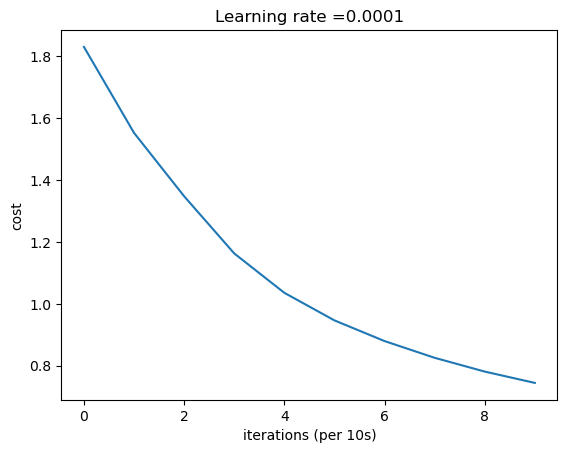

In [175]:
# Plot the cost
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per 10s)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

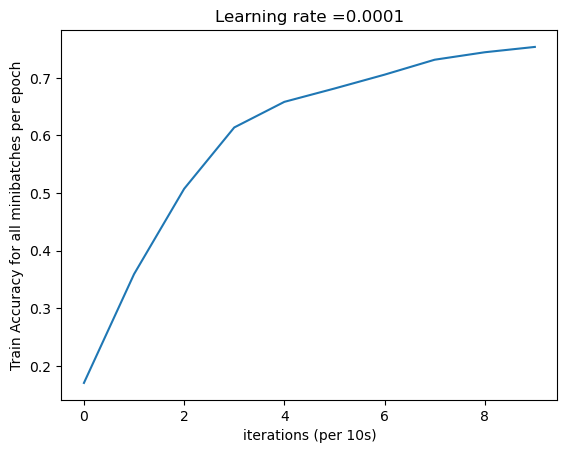

In [176]:
# Plot the train accuracy
plt.plot(np.squeeze(train_acc), label="Train")
plt.ylabel('Train Accuracy for all minibatches per epoch')
plt.xlabel('iterations (per 10s)')
plt.title("Learning rate =" + str(0.0001))
plt.show()

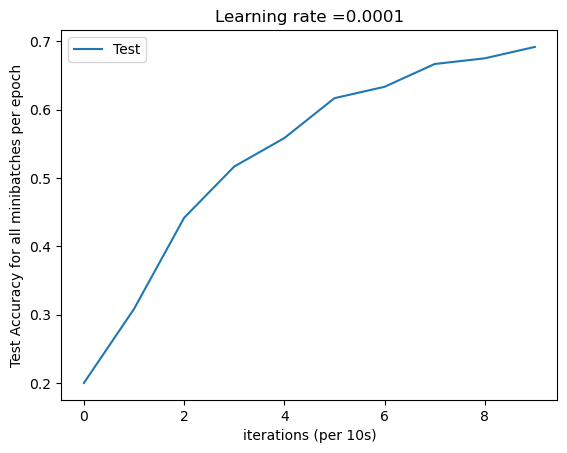

In [177]:
# Plot the test accuracy
plt.plot(np.squeeze(test_acc), label="Test")
plt.ylabel('Test Accuracy for all minibatches per epoch')
plt.xlabel('iterations (per 10s)')
plt.title("Learning rate =" + str(0.0001))
plt.legend()
plt.show()

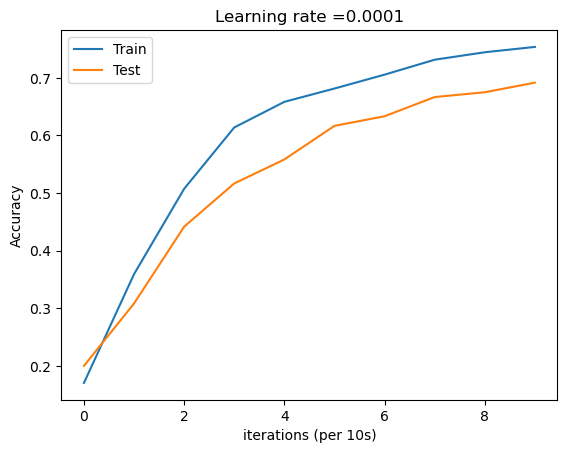

In [178]:
plt.plot(np.squeeze(train_acc), label="Train")
plt.plot(np.squeeze(test_acc), label="Test")
plt.ylabel("Accuracy")
plt.xlabel('iterations (per 10s)')
plt.title("Learning rate =" + str(0.0001))
plt.legend()
plt.show()

    Congratulations! You've made it to the end of this assignment, and to the end of this week's material. Amazing work building a neural network in TensorFlow 2.3!

    Here's a quick recap of all you just achieved:

- Used tf.Variable to modify your variables
- Trained a Neural Network on a TensorFlow dataset
- You are now able to harness the power of TensorFlow to create cool things, faster. Nice!


### 4 - Bibliography
    In this assignment, you were introducted to tf.GradientTape, which records operations for differentation. Here are a couple of resources for diving deeper into what it does and why:

Introduction to Gradients and Automatic Differentiation: https://www.tensorflow.org/guide/autodiff

GradientTape documentation: https://www.tensorflow.org/api_docs/python/tf/GradientTape

In [ ]:
#Self Practice

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
%matplotlib inline

In [87]:
#dataset Loading
train_data = h5py.File("./data/train_signs.h5", "r")
train_X = train_data["train_set_x"]
train_Y = train_data["train_set_y"]

test_data = h5py.File("./data/test_signs.h5", "r")
test_X = test_data["test_set_x"]
test_Y = test_data["test_set_y"]

#coverting the data to tensor slices to generate data slices instead of loading whole at once
train_X = tf.data.Dataset.from_tensor_slices(train_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)

test_X = tf.data.Dataset.from_tensor_slices(test_X)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)


print(type(train_X))
print(train_X._tensors[0].shape)
print(train_Y._tensors[0].shape)
print(test_X._tensors[0].shape)
print(test_Y._tensors[0].shape)
print(train_X.element_spec)
print(train_Y.element_spec)

unique_labels = set()
for label in train_Y:
    unique_labels.add(label.numpy())
print("Classes: "+str(unique_labels))

#Transformation of input X, normalize, reshape and then use map to transform
def normalize(image):
    image_scaled = tf.cast(image, tf.float32) / 255.0
    image_reshaped = tf.reshape(image_scaled, [-1,])
    return image_reshaped

train_X_transformed = train_X.map(normalize)
test_X_transformed = test_X.map(normalize)
print(train_X_transformed.element_spec)

print(type(train_X_transformed))
print(train_X_transformed)
print(next(iter(train_X_transformed)))

#onehotencode of target
def one_hot_matrix(label, depth=6):
    label_onehot = tf.one_hot(indices=label, depth=depth, axis=0)
    label_onehot_reshaped = tf.reshape(label_onehot, (depth,))
    return label_onehot_reshaped

new_train_Y = train_Y.map(one_hot_matrix)
new_test_Y = test_Y.map(one_hot_matrix)

print(type(new_train_Y))
print(new_train_Y)
print(next(iter(new_train_Y)))

#initialization of parameters
def initialize_params():
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    W1 = tf.Variable(initializer(shape=(25, 12288)), dtype=tf.float32)
    b1 = tf.Variable(initializer(shape=(25, 1)), dtype=tf.float32)
    W2 = tf.Variable(initializer(shape=(12, 25)), dtype=tf.float32)
    b2 = tf.Variable(initializer(shape=(12, 1)), dtype=tf.float32)
    W3 = tf.Variable(initializer(shape=(6, 12)), dtype=tf.float32)
    b3 = tf.Variable(initializer(shape=(6, 1)), dtype=tf.float32)
    params = {"W1" : W1, "b1" : b1, "W2" : W2, "b2" : b2, "W3" : W3, "b3" : b3}
    return params

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
(1080, 64, 64, 3)
(1080,)
(120, 64, 64, 3)
(120,)
TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None)
TensorSpec(shape=(), dtype=tf.int64, name=None)
Classes: {0, 1, 2, 3, 4, 5}
TensorSpec(shape=(12288,), dtype=tf.float32, name=None)
<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<_MapDataset element_spec=TensorSpec(shape=(12288,), dtype=tf.float32, name=None)>
tf.Tensor([0.8901961  0.8627451  0.8392157  ... 0.8156863  0.81960785 0.81960785], shape=(12288,), dtype=float32)
<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<_MapDataset element_spec=TensorSpec(shape=(6,), dtype=tf.float32, name=None)>
tf.Tensor([0. 0. 0. 0. 0. 1.], shape=(6,), dtype=float32)


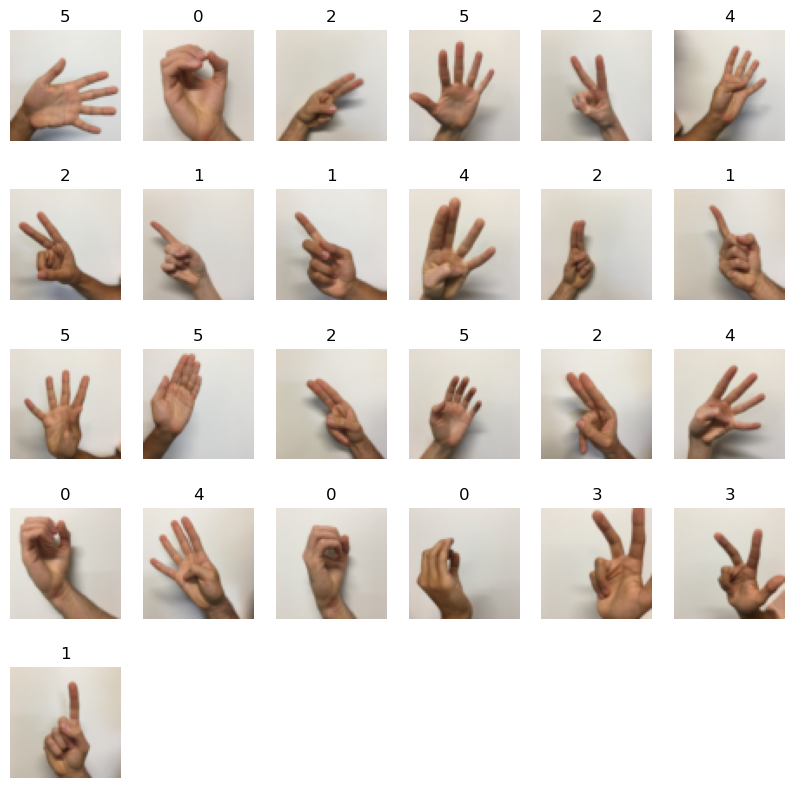

In [95]:
#print the images
images_train = iter(train_X)
images_label = iter(train_Y)
figure = plt.figure(figsize=(10, 10))
for i in range(25):
    axes = plt.subplot(5, 6, i+1)
    plt.imshow(next(images_train).numpy().astype("uint8"))
    plt.title(next(images_label).numpy().astype("uint8"))
    plt.axis("off")
plt.show()
    

In [114]:
#Forward propagation
def forward_propagation(X, params):
    W1, b1, W2, b2, W3, b3 = params.values()
    
    Z1 = tf.math.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    
    return Z3

#Cost Function
def compute_cost(logits, labels):
    cost = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(labels, tf.transpose(logits), from_logits=True))
    return cost

#Model
def model(X_train, Y_train, X_test, Y_test, num_epochs=1500, learning_rate=0.0001, mini_batch_size=32, print_cost=True):
    costs = []
    train_acc = []
    test_acc = []
    params = initialize_params()
    W1, b1, W2, b2, W3, b3 = params["W1"], params["b1"], params["W2"], params["b2"], params["W3"], params["b3"]
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    train_dataset = tf.data.Dataset.zip((X_train, Y_train)) #slices - data generator
    test_dataset = tf.data.Dataset.zip((X_test, Y_test))
    
    mini_batches_train = train_dataset.batch(mini_batch_size).prefetch(8)
    mini_batches_test = test_dataset.batch(mini_batch_size).prefetch(8)
    
    train_accuracy = tf.keras.metrics.CategoricalAccuracy()
    test_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    m = train_dataset.cardinality().numpy()
    
    for epoch in range(num_epochs):
        total_epoch_cost = 0.0
        train_accuracy.reset_states()
        
        for (mini_batch_X, mini_batch_Y) in mini_batches_train:
            with tf.GradientTape() as tape:
                Z3 = forward_propagation(tf.transpose(mini_batch_X), params)
                mini_batch_cost = compute_cost(Z3, mini_batch_Y)
            
            trainable_variables = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(mini_batch_cost, trainable_variables)
            optimizer.apply_gradients(zip(grads, trainable_variables)) 
            
            total_epoch_cost += mini_batch_cost
            train_accuracy.update_state(tf.transpose(Z3), mini_batch_Y)
            
        total_epoch_cost /= m
        
        if print_cost and epoch % 10 == 0:
            print("After epoch %d, the cost is: %f" %(epoch, total_epoch_cost))
            costs.append(total_epoch_cost)
            
            print("Train Accuracy : "+str(train_accuracy.result()))
            train_acc.append(train_accuracy.result())
    
            for (mini_batch_X, mini_batch_Y) in mini_batches_test:
                Z3 = forward_propagation(tf.transpose(mini_batch_X), params)
                test_accuracy.update_state(tf.transpose(Z3), mini_batch_Y)
            
            print("Test Accuracy : "+str(test_accuracy.result()))
            test_acc.append(test_accuracy.result())
            test_accuracy.reset_states()
            
    return params, costs, train_acc, test_acc

params, costs, train_acc, test_acc = model(train_X_transformed, new_train_Y, test_X_transformed, new_test_Y, num_epochs=100, learning_rate=0.0001, mini_batch_size=32, print_cost=True)


After epoch 0, the cost is: 1.830244
Train Accuracy : tf.Tensor(0.17037037, shape=(), dtype=float32)
Test Accuracy : tf.Tensor(0.2, shape=(), dtype=float32)
After epoch 10, the cost is: 1.552391
Train Accuracy : tf.Tensor(0.35925925, shape=(), dtype=float32)
Test Accuracy : tf.Tensor(0.30833334, shape=(), dtype=float32)
After epoch 20, the cost is: 1.347617
Train Accuracy : tf.Tensor(0.5074074, shape=(), dtype=float32)
Test Accuracy : tf.Tensor(0.44166666, shape=(), dtype=float32)
After epoch 30, the cost is: 1.162812
Train Accuracy : tf.Tensor(0.61388886, shape=(), dtype=float32)
Test Accuracy : tf.Tensor(0.51666665, shape=(), dtype=float32)
After epoch 40, the cost is: 1.035599
Train Accuracy : tf.Tensor(0.65833336, shape=(), dtype=float32)
Test Accuracy : tf.Tensor(0.55833334, shape=(), dtype=float32)
After epoch 50, the cost is: 0.946474
Train Accuracy : tf.Tensor(0.6814815, shape=(), dtype=float32)
Test Accuracy : tf.Tensor(0.6166667, shape=(), dtype=float32)
After epoch 60, the c

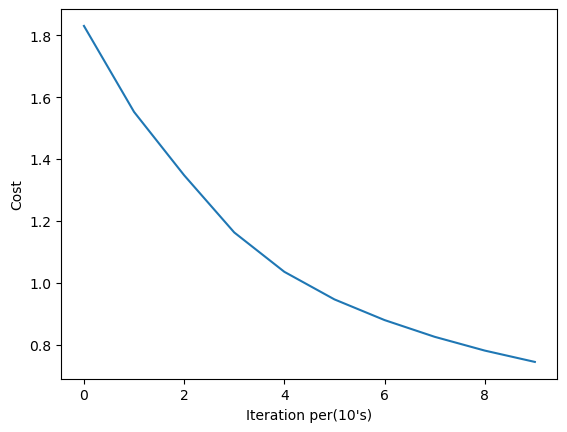

In [115]:
#Plotting
plt.plot(costs)
plt.xlabel("Iteration per(10's)")
plt.ylabel("Cost")
plt.show()

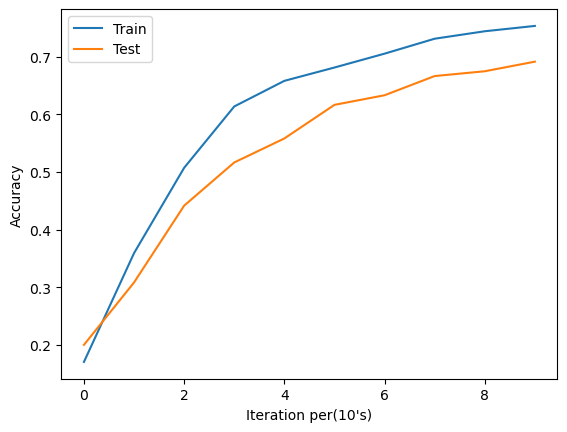

In [117]:
#Plotting
plt.plot(train_acc, label="Train")
plt.plot(test_acc, label="Test")
plt.xlabel("Iteration per(10's)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()